# Tutorial 3. Use SEDR to do batch integration.

Here we use 3 sections from DLPFC data to show the ability of SEDR to integrate batches for the same tissue with the same techniques. 

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, \
    contingency_matrix
import torch.backends.cudnn as cudnn

cudnn.deterministic = True
cudnn.benchmark = True
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\R\R-4.3.3'
os.environ['R_USER'] = 'D:\Anaconda3\envs\Spoint\Lib\site-packages/rpy2'



def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='model_pred', key_added_pred="mclust", random_seed=2024):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added_pred] = mclust_res
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata

In [2]:
import SEDR

ModuleNotFoundError: No module named 'SEDR'

from graph_func import graph_construction
proj_name = '151673'
data_root = Path('E:\实验数据\DLPFC\DLPFC')
####"E:\实验数据\DLPFC\DLPFC\151673\151673_filtered_feature_bc_matrix.h5"
adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
adata_tmp.var_names_make_unique()

adata_tmp.obs['batch_name'] = proj_name

##### Load layer_guess label, if have,   "E:\实验数据\DLPFC\DLPFC\151673\151673_truth.txt"
truth_path = "E:\实验数据\DLPFC\DLPFC" + proj_name + '/' + proj_name + '_truth.txt'
Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
"""df_label = pd.read_csv(data_root / proj_name / 'metadata.tsv', sep='\t')
adata_tmp.obs['layer_guess'] = df_label['layer_guess']"""
adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

graph_dict_tmp =graph_construction(adata_tmp, 12)
adata = adata_tmp
graph_dict = graph_dict_tmp
name = proj_name
adata.obs['proj_name'] = proj_name
adata

graph_dict_tmp['adj_norm'].to_dense()

In [3]:
data_root = Path('D:\pythonplaces\deconv-mulST\Result\Dataset4')

proj_list = [
    '151673', '151674', '151675','151676'
]

## Combining datasets

Input of SEDR includes an AnnData object that contains the spatial transcriptomics data and a graph dictionary that contains the neighborhood graph. When combining two datasets, the AnnData objects are directly concatenated. For neighborhood graphs, we follow the following algorithm.  
Let $A^k$ and $Z_f^k$ denote the adjacency matrix and deep gene representation of spatial omics k, we then create a block-diagonal adjacency matrix $A^k$  and concatenate the deep gene representation in the spot dimension, as:  
![](batch_integration.png)  
where K is the number of spatial omics. 


In [4]:
def mapping2int(string_array):
    mapping = {}  # 创建一个空字典用于存储字符串到数字的映射关系
    result = []

    for string in string_array:
        if string not in mapping:
            # 如果字符串不在映射字典中，则将其添加，并分配一个新的数字
            mapping[string] = len(mapping)
        # 将字符串转换成相应的数字并添加到结果数组中
        result.append(mapping[string])

    return result, mapping

In [4]:
proj_list

NameError: name 'proj_list' is not defined

In [6]:
result, mapping = mapping2int(proj_list)

In [7]:
mapping

{'151673': 0, '151674': 1, '151675': 2, '151676': 3}

In [3]:
from tqdm import tqdm
from graph_func import graph_construction,combine_graph_dict
import anndata as ad
for proj_name in tqdm(proj_list):
    fname = [f"st{proj_name}.h5ad"]
    fpath = os.path.join(data_root, fname)
    print(fpath)
    adata_tmp = ad.read_h5ad(fpath)
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    adata_tmp.obs['slice_id'] =  mapping[proj_name]

    ##### Load layer_guess label, if have
    # truth_path = "E:\实验数据\DLPFC\DLPFC/" + proj_name + '/' + proj_name + '_truth.txt'
    # Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
    # Ann_df.columns = ['Ground Truth']
    # """df_label = pd.read_csv(data_root / proj_name / 'metadata.tsv', sep='\t')
    # adata_tmp.obs['layer_guess'] = df_label['layer_guess']"""
    # adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
    # adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]
    # 
    # graph_dict_tmp = graph_construction(adata_tmp, 12)
    # if proj_name == proj_list[0]:
    #     adata = adata_tmp
    #     graph_dict = graph_dict_tmp
    #     name = proj_name
    #     adata.obs['proj_name'] = proj_name
    # else:
    #     var_names = adata.var_names.intersection(adata_tmp.var_names)
    #     adata = adata[:, var_names]
    #     adata_tmp = adata_tmp[:, var_names]
    #     adata_tmp.obs['proj_name'] = proj_name
    # 
    #     adata = adata.concatenate(adata_tmp)
    #     graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
    #     name = name + '_' + proj_name
    
from tqdm import tqdm
from graph_func import graph_construction,combine_graph_dict
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    adata_tmp.obs['slice_id'] =  mapping[proj_name]

    ##### Load layer_guess label, if have
    truth_path = "E:\实验数据\DLPFC\DLPFC/" + proj_name + '/' + proj_name + '_truth.txt'
    Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    """df_label = pd.read_csv(data_root / proj_name / 'metadata.tsv', sep='\t')
    adata_tmp.obs['layer_guess'] = df_label['layer_guess']"""
    adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
    adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

    graph_dict_tmp = graph_construction(adata_tmp, 12)
    if proj_name == proj_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name

        adata = adata.concatenate(adata_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

NameError: name 'proj_list' is not defined

## Preprocessing

In [11]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 

adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [12]:
adata

AnnData object with n_obs × n_vars = 14243 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca'
    layers: 'count'

In [21]:
#
import time
import numpy as np
import torch
import torch.nn.modules.loss
import torch.nn.functional as F
from sklearn.cluster import KMeans
from SEDR_module import SEDR_module, SEDR_impute_module
from tqdm import tqdm



def target_distribution(batch):
    weight = (batch ** 2) / torch.sum(batch, 0)
    return (weight.t() / torch.sum(weight, 1)).t()


def reconstruction_loss(decoded, x):
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    return loss_rcn


# def gcn_loss(preds, labels, mu, logvar, n_nodes, norm, mask=None):
#     if mask is not None:
#         preds = preds * mask
#         labels = labels * mask
#
#     cost = norm * F.binary_cross_entropy_with_logits(preds, labels)
#
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 / n_nodes * torch.mean(torch.sum(
#         1 + 2 * logvar - mu.pow(2) - logvar.exp().pow(2), 1))
#     return cost + KLD



def gcn_loss(preds, labels, mu, logvar, n_nodes, norm):
    cost = norm * F.binary_cross_entropy_with_logits(preds, labels)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 / n_nodes * torch.mean(torch.sum(
        1 + 2 * logvar - mu.pow(2) - logvar.exp().pow(2), 1))
    return cost + KLD


class Sedr:
    def __init__(
            self,
            X,
            graph_dict,
            rec_w=10,
            gcn_w=0.1,
            self_w=1,
            dec_kl_w=1,
            mode = 'clustering',
            device = 'cuda:0',
    ):

        self.rec_w = rec_w
        self.gcn_w = gcn_w
        self.self_w = self_w
        self.dec_kl_w = dec_kl_w
        self.device = device
        self.mode = mode

        if 'mask' in graph_dict:
            self.mask = True
            self.adj_mask = graph_dict['mask'].to(self.device)
        else:
            self.mask = False

        self.cell_num = len(X)

        self.X = torch.FloatTensor(X.copy()).to(self.device)
        self.input_dim = self.X.shape[1]

        self.adj_norm = graph_dict["adj_norm"].to(self.device)
        self.adj_label = graph_dict["adj_label"].to(self.device)

        self.norm_value = graph_dict["norm_value"]

        if self.mode == 'clustering':
            self.model = SEDR_module(self.input_dim).to(self.device)
        elif self.mode == 'imputation':
            self.model = SEDR_impute_module(self.input_dim).to(self.device)
        else:
            raise ValueError(f'{self.mode} is not currently supported!')


    def mask_generator(self, N=1):
        idx = self.adj_label.indices()

        list_non_neighbor = []
        for i in range(0, self.cell_num):
            neighbor = idx[1, torch.where(idx[0, :] == i)[0]]
            n_selected = len(neighbor) * N

            # non neighbors
            total_idx = torch.range(0, self.cell_num-1, dtype=torch.float32).to(self.device)
            non_neighbor = total_idx[~torch.isin(total_idx, neighbor)]
            indices = torch.randperm(len(non_neighbor), dtype=torch.float32).to(self.device)
            random_non_neighbor = indices[:n_selected]
            list_non_neighbor.append(random_non_neighbor)

        x = torch.repeat_interleave(self.adj_label.indices()[0], N)
        y = torch.concat(list_non_neighbor)

        indices = torch.stack([x, y])
        indices = torch.concat([self.adj_label.indices(), indices], axis=1)

        value = torch.concat([self.adj_label.values(), torch.zeros(len(x), dtype=torch.float32).to(self.device)])
        adj_mask = torch.sparse_coo_tensor(indices, value)

        return adj_mask

    def train_without_dec(
            self,
            epochs=200,
            lr=0.01,
            decay=0.01,
            N=1,
    ):
        self.optimizer = torch.optim.Adam(
            params=list(self.model.parameters()),
            lr=lr,
            weight_decay=decay)

        self.model.train()

        # list_rec = []
        # list_gcn = []
        # list_self = []
        for _ in tqdm(range(epochs)):
            self.model.train()
            self.optimizer.zero_grad()
            latent_z, mu, logvar, de_feat, _, feat_x, _, loss_self = self.model(self.X, self.adj_norm)

            if self.mask:
                pass
            else:

                if self.mode == 'imputation':
                    adj_mask = self.mask_generator(N=0)
                else:
                    adj_mask = self.mask_generator(N=1)
                self.adj_mask = adj_mask
                self.mask = True


            loss_gcn = gcn_loss(
                preds=self.model.dc(latent_z, self.adj_mask),
                # labels=self.adj_label,
                labels=self.adj_mask.coalesce().values(),
                mu=mu,
                logvar=logvar,
                n_nodes=self.cell_num,
                norm=self.norm_value,
            )

            loss_rec = reconstruction_loss(de_feat, self.X)
            loss = self.rec_w * loss_rec + self.gcn_w * loss_gcn + self.self_w * loss_self
            loss.backward()
            self.optimizer.step()

        #     list_rec.append(loss_rec.detach().cpu().numpy())
        #     list_gcn.append(loss_gcn.detach().cpu().numpy())
        #     list_self.append(loss_self.detach().cpu().numpy())
        #
        # import matplotlib.pyplot as plt
        # fig, ax = plt.subplots()
        # ax.plot(list_rec, label='rec')
        # ax.plot(list_gcn, label='gcn')
        # ax.plot(list_self, label='self')
        # ax.legend()
        # plt.show()


    def save_model(self, save_model_file):
        torch.save({'state_dict': self.model.state_dict()}, save_model_file)
        print('Saving model to %s' % save_model_file)

    def load_model(self, save_model_file):
        saved_state_dict = torch.load(save_model_file)
        self.model.load_state_dict(saved_state_dict['state_dict'])
        print('Loading model from %s' % save_model_file)

    def process(self):
        self.model.eval()
        latent_z, _, _, de_feat, q, feat_x, gnn_z, _ = self.model(self.X, self.adj_norm)
        
        latent_z = latent_z.data.cpu().numpy()
        de_feat = de_feat.data.cpu().numpy()
        q = q.data.cpu().numpy()
        feat_x = feat_x.data.cpu().numpy()
        gnn_z = gnn_z.data.cpu().numpy()
        
        return latent_z, q, feat_x, gnn_z, de_feat

    def recon(self):
        self.model.eval()
        latent_z, _, _, de_feat, q, feat_x, gnn_z, _ = self.model(self.X, self.adj_norm)
        de_feat = de_feat.data.cpu().numpy()

        # revise std and mean
        from sklearn.preprocessing import StandardScaler
        out = StandardScaler().fit_transform(de_feat)

        return out

    def train_with_dec(
            self,
            epochs=200,
            dec_interval=20,
            dec_tol=0.00,
            N=1,
    ):
        # initialize cluster parameter
        # self.train_without_dec(
        #     epochs=epochs,
        #     lr=lr,
        #     decay=decay,
        #     N=N,
        # )
        self.train_without_dec()

        kmeans = KMeans(n_clusters=self.model.dec_cluster_n, n_init=self.model.dec_cluster_n * 2, random_state=42)
        test_z, _, _, _, _ = self.process()
        y_pred_last = np.copy(kmeans.fit_predict(test_z))

        self.model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(self.device)
        self.model.train()

        for epoch_id in tqdm(range(epochs)):
            # DEC clustering update
            if epoch_id % dec_interval == 0:
                _, tmp_q, _, _, _ = self.process()
                tmp_p = target_distribution(torch.Tensor(tmp_q))
                y_pred = tmp_p.cpu().numpy().argmax(1)
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                self.model.train()
                if epoch_id > 0 and delta_label < dec_tol:
                    print('delta_label {:.4}'.format(delta_label), '< tol', dec_tol)
                    print('Reached tolerance threshold. Stopping training.')
                    break

            # training model
            torch.set_grad_enabled(True)
            self.optimizer.zero_grad()
            latent_z, mu, logvar, de_feat, out_q, _, _, _ = self.model(self.X, self.adj_norm)

            # if self.mask:
            #     pass
            # else:
            #     adj_mask = self.mask_generator(N)
            #     self.adj_mask = adj_mask
            #     self.mask = True

            loss_gcn = gcn_loss(
                preds=self.model.dc(latent_z, self.adj_mask),
                labels=self.adj_mask.coalesce().values(),
                mu=mu,
                logvar=logvar,
                n_nodes=self.cell_num,
                norm=self.norm_value,
                # mask=adj_mask,
            )
            loss_rec = reconstruction_loss(de_feat, self.X)
            # clustering KL loss
            loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
            loss = self.gcn_w * loss_gcn + self.dec_kl_w * loss_kl + self.rec_w * loss_rec
            loss.backward()
            self.optimizer.step()





## Training SEDR

In [22]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# from SEDR_model import *
sedr_net = Sedr(adata.X, graph_dict=graph_dict, mode='imputation', device=device)

import time
# 统计运行时间
torch.cuda.synchronize()  # 确保 CUDA 操作完成
start_time = time.time()
using_dec = True
if using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
    
torch.cuda.synchronize()  # 确保所有操作结束
end_time = time.time()
print(f"模型运行时间: {end_time - start_time:.4f} 秒")

# 统计 GPU 内存使用情况
print(f"显存使用情况: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
print(f"显存缓存情况: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")
sedr_feat, _, _, _, de_feat = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat
adata.obsm['recon'] = de_feat

100%|██████████| 200/200 [00:03<00:00, 62.84it/s]

模型运行时间: 13.5097 秒
显存使用情况: 1109.13 MB
显存缓存情况: 3612.00 MB


In [24]:
# import rpy2.robjects as robjects
# 
# # 使用 CRAN 镜像安装 R 包
# robjects.r('install.packages("mclust", repos="https://cloud.r-project.org")')


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.3/mclust_6.1.1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4119664 bytes (3.9 MB)

R[write to console]: downloaded 3.9 MB




package 'mclust' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\DELL\AppData\Local\Temp\Rtmpgl1bcJ\downloaded_packages


In [27]:
# 如果不报错，说明 mclust 包已经安装成功
# robjects.r('library(mclust)')
adata

AnnData object with n_obs × n_vars = 14243 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'SEDR', 'recon'
    layers: 'count'

In [42]:
# def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='model_pred', key_added_pred="mclust", random_seed=2024):
#     import rpy2.robjects as robjects
#     import rpy2.robjects.numpy2ri
#     import numpy as np
# 
#     if used_obsm not in adata.obsm:
#         raise ValueError(f"{used_obsm} not found in adata.obsm.")
# 
#     data = adata.obsm[used_obsm]
#     if data.ndim != 2 or data.shape[0] == 0 or data.shape[1] == 0:
#         raise ValueError(f"adata.obsm['{used_obsm}'] must be a non-empty 2D array. Got shape {data.shape}.")
# 
#     rpy2.robjects.numpy2ri.activate()
# 
#     r_random_seed = robjects.r['set.seed']
#     r_random_seed(random_seed)
#     rmclust = robjects.r['Mclust']
# 
#     try:
#         res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(data), G=num_cluster, modelNames=modelNames)
#         if res.rclass[0] != 'Mclust':
#             raise RuntimeError("Mclust did not return a valid result.")
#         # mclust_res = np.array(res.rx2('classification')).astype(int)
#         mclust_res = np.array(res[-2])
#     except Exception as e:
#         raise RuntimeError(f"Failed to run Mclust on data. Check input and R setup. Error: {e}")
# 
#     adata.obs[key_added_pred] = pd.Categorical(mclust_res)
#     return adata
# 
# adata = mclust_R(adata, num_cluster=7, used_obsm='SEDR', key_added_pred='mclust')
from sklearn.cluster import KMeans
def Kmeans_cluster(adata, num_cluster, used='latent', key_added_pred="G3STNET", random_seed=2024):
    np.random.seed(random_seed)
    cluster_model = KMeans(n_clusters=num_cluster, init='k-means++', n_init=100, max_iter=1000, tol=1e-6)
    cluster_labels = cluster_model.fit_predict(adata.obsm[used])
    adata.obs[key_added_pred] = cluster_labels
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata
adata = Kmeans_cluster(adata, num_cluster=7, used='SEDR', key_added_pred='mclust', random_seed=42)
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"ARI:{ARI}")

ARI:0.26705095727537154


## use harmony to calculate revised PCs

In [43]:
import harmonypy as hm

meta_data = adata.obs[['batch']]

data_mat = adata.obsm['SEDR']
vars_use = ['batch']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i + 1) for i in range(res.shape[1])],
                      index=adata.obs.index)
adata.obsm[f'SEDR.Harmony'] = res_df

2025-04-29 19:19:12,289 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-29 19:19:14,733 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-29 19:19:14,787 - harmonypy - INFO - Iteration 1 of 10
2025-04-29 19:19:16,579 - harmonypy - INFO - Iteration 2 of 10
2025-04-29 19:19:17,257 - harmonypy - INFO - Iteration 3 of 10
2025-04-29 19:19:17,956 - harmonypy - INFO - Converged after 3 iterations


In [44]:
adata.obsm['SEDR'].shape

(14243, 32)

In [45]:
adata.obsm[f'SEDR.Harmony'] = res_df.to_numpy()

In [46]:
# adata = mclust_R(adata, num_cluster=7, used_obsm='SEDR.Harmony', key_added_pred='mclust_H')
adata = Kmeans_cluster(adata, num_cluster=7, used='SEDR.Harmony', key_added_pred='mclust_H', random_seed=42)
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust_H'])
print(f"ARI:{ARI}")

ARI:0.263407450664654


In [47]:
sc.write('D:\pythonplaces\SEDR\Result\DLPFC/adata_concat_sedr2.h5ad',adata)

## Visualizing

### UMAP

[<Axes: title={'center': 'layer_guess'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'mclust'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch_name'}, xlabel='UMAP1', ylabel='UMAP2'>]

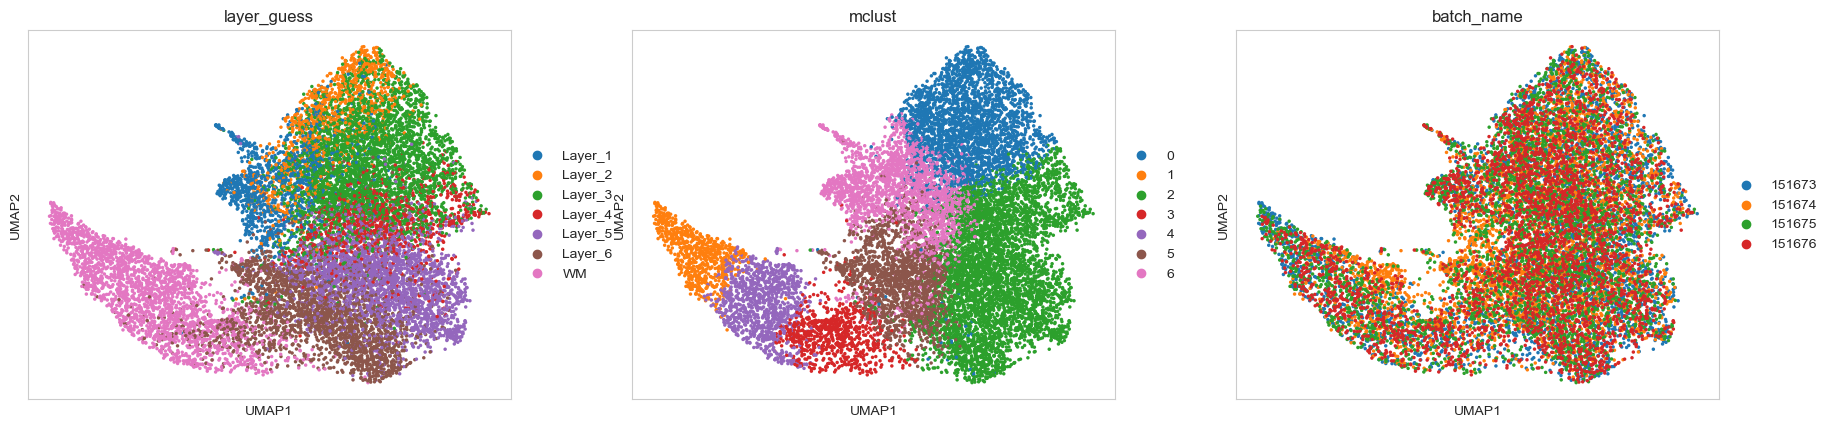

In [48]:
sc.pp.neighbors(adata, use_rep='SEDR.Harmony', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=False, size=25)

In [49]:
sc.write("D:\pythonplaces\SEDR\Result\DLPFC/SEDR_H_sample2.h5ad",adata)

### LISI score

In [50]:
ILISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['proj_name']], label_colnames=['proj_name'])[:, 0]
CLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]

In [51]:
def calculate_F1LISI(LISI_domain_norm, LISI_batch_norm):
    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI
F1LISI = calculate_F1LISI( CLISI, ILISI)

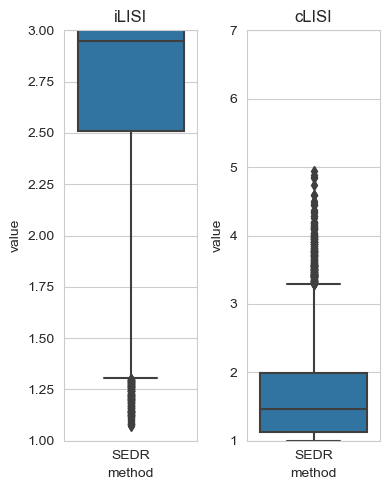

In [52]:
df_ILISI = pd.DataFrame({
    'method': 'SEDR',
    'value': ILISI,
    'type': ['ILISI'] * len(ILISI)
})

df_CLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': CLISI,
    'type': ['CLISI'] * len(CLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()

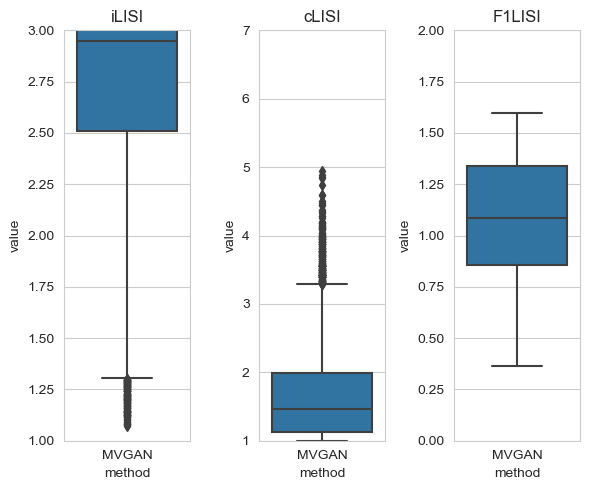

In [53]:
df_ILISI = pd.DataFrame({
    'method': 'MVGAN',
    'value': ILISI,
    'type': ['ILISI'] * len(ILISI)
})

df_CLISI = pd.DataFrame({
    'method': 'MVGAN',
    'value': CLISI,
    'type': ['CLISI'] * len(CLISI)
})

df_F1LISI = pd.DataFrame({
    'method': 'MVGAN',
    'value': F1LISI,
    'type': ['F1LISI'] * len(F1LISI)
})

fig, axes = plt.subplots(1, 3, figsize=(6, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
sns.boxplot(data=df_F1LISI, x='method', y='value', ax=axes[2])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[2].set_ylim(0, 2)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')
axes[2].set_title('F1LISI')
plt.tight_layout()

In [57]:
import squidpy as sq


def marker_score(adata, domain_key, top_n=5, attr='obsm', layer='recon'):
    adata = adata.copy()
    count_dict = adata.obs[domain_key].value_counts()
    adata = adata[adata.obs[domain_key].isin(count_dict.keys()[count_dict > 3].values)]
    # sc.pp.normalize_per_cell(adata)
    # sc.pp.log1p(adata)
    sc.tl.rank_genes_groups(adata, groupby=domain_key)
    global_genes = adata.var_names.values
    selected_genes = []
    for i in range(top_n):
        toadd = list(adata.uns['rank_genes_groups']['names'][i])
        selected_genes.extend(toadd)
    selected_genes = np.unique(selected_genes)
    sq.gr.spatial_neighbors(adata)
    use_idx = np.where(np.in1d(global_genes, selected_genes))[0]
    sq.gr.spatial_autocorr(
        adata,
        attr=attr,
        layer=layer,
        mode="moran",
        genes=use_idx,
        n_perms=100,
        n_jobs=1,
    )
    sq.gr.spatial_autocorr(
        adata,
        attr=attr,
        layer=layer,
        mode="geary",
        genes=use_idx,
        n_perms=100,
        n_jobs=1,
    )
    moranI = np.median(adata.uns["moranI"]['I'])
    gearyC = np.median(adata.uns["gearyC"]['C'])
    return moranI, gearyC, adata

In [55]:
moranI, gearyC, tmp_adata = marker_score(adata, domain_key='mclust_H', top_n=100)
moranI, gearyC

TypeError: spatial_autocorr() got an unexpected keyword argument 'attr'

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

GearyC = tmp_adata.uns["gearyC"]['C']
MoranI = tmp_adata.uns["moranI"]['I']

df_GearyC = pd.DataFrame({
    'method': 'MVGAN',
    'value': GearyC,
    'type': ['GearyC'] * len(GearyC)
})

df_MoranI = pd.DataFrame({
    'method': 'MVGAN',
    'value': MoranI,
    'type': ['MoranI'] * len(MoranI)
})

fig, axes = plt.subplots(1, 2, figsize=(6, 5))
sns.boxplot(data=df_GearyC, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_MoranI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[0].set_title('GearyC')
axes[1].set_title('MoranI')
plt.tight_layout()

NameError: name 'tmp_adata' is not defined

In [58]:
sc.write(r'D:\pythonplaces\SEDR\Result\DLPFC\SEDR_sample3.h5ad',adata)

In [59]:
adata

AnnData object with n_obs × n_vars = 14243 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch', 'mclust', 'mclust_H'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'umap', 'layer_guess_colors', 'mclust_colors', 'batch_name_colors'
    obsm: 'spatial', 'X_pca', 'SEDR', 'recon', 'SEDR.Harmony', 'X_umap'
    layers: 'count'
    obsp: 'distances', 'connectivities'